In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import HiveContext
from pyspark.ml.regression import LinearRegression

In [2]:
#Create a Spark Application
spark = SparkSession.builder \
.appName("ReadingFromHive") \
.master("local") \
.enableHiveSupport() \
.getOrCreate()

In [3]:
df = spark.read.csv('file:///home/hduser/demo_1/Linear_regression_dataset.csv',sep=',',inferSchema=True,header=True )

In [4]:
df.show(2)


+-----+-----+-----+-----+-----+------+
|var_1|var_2|var_3|var_4|var_5|output|
+-----+-----+-----+-----+-----+------+
|  734|  688|   81|0.328|0.259| 0.418|
|  700|  600|   94| 0.32|0.247| 0.389|
+-----+-----+-----+-----+-----+------+
only showing top 2 rows



In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

df_pd = df.toPandas()
plt.figure(figsize=(10,10))
sns.pairplot(data=df_pd)
plt.show()

<Figure size 1000x1000 with 0 Axes>

<Figure size 1500x1500 with 42 Axes>

In [6]:
df_pd.corr()

,var_1,var_2,var_3,var_4,var_5,output
var_1,1.000000,0.380139,0.511745,0.900492,0.827000,0.918740
var_2,0.380139,1.000000,-0.532394,0.326360,0.330764,0.436527
var_3,0.511745,-0.532394,1.000000,0.481836,0.408716,0.401496
var_4,0.900492,0.326360,0.481836,1.000000,0.851958,0.790910
var_5,0.827000,0.330764,0.408716,0.851958,1.000000,0.790481
output,0.918740,0.436527,0.401496,0.790910,0.790481,1.000000


In [7]:
print(df.count(),len(df.columns))

1232 6


In [8]:
df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)



In [9]:
df.describe().show(2,False)

+-------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+
|summary|var_1            |var_2            |var_3            |var_4             |var_5              |output             |
+-------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+
|count  |1232             |1232             |1232             |1232              |1232               |1232               |
|mean   |715.0819805194806|715.0819805194806|80.90422077922078|0.3263311688311693|0.25927272727272715|0.39734172077922014|
+-------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+
only showing top 2 rows



In [10]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [11]:
#create the vector assembler 
vec_assmebler=VectorAssembler(inputCols=['var_1', 'var_2', 'var_3', 'var_4', 'var_5'],outputCol='features')

In [12]:
features_df = vec_assmebler.transform(df)

In [13]:
features_df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)
 |-- features: vector (nullable = true)



In [14]:
model_df = features_df.select('features','output')

In [15]:
model_df.show(5)

+--------------------+------+
|            features|output|
+--------------------+------+
|[734.0,688.0,81.0...| 0.418|
|[700.0,600.0,94.0...| 0.389|
|[712.0,705.0,93.0...| 0.417|
|[734.0,806.0,69.0...| 0.415|
|[613.0,759.0,61.0...| 0.378|
+--------------------+------+
only showing top 5 rows



In [16]:
print(model_df.count(),len(model_df.columns))

1232 2


In [17]:
train_df,test_df = model_df.randomSplit([0.7,0.3])

In [18]:
print(train_df.count(),len(train_df.columns))

865 2


In [19]:
print(test_df.count(),len(test_df.columns))

367 2


In [20]:
lin_reg = LinearRegression(labelCol='output')

In [21]:
lr_model = lin_reg.fit(train_df)

In [22]:
lr_model.intercept

0.18833964176240198

In [23]:
print(lr_model.coefficients)

[0.00034035540316583695,5.282472186025761e-05,0.00020084490556201905,-0.692676286545367,0.528132595482702]


In [24]:
training_prediction = lr_model.evaluate(train_df)

In [25]:
training_prediction.r2

0.8708003680817069

In [26]:
training_prediction.meanSquaredError

0.0001453538991528993

In [27]:
test_result = lr_model.evaluate(test_df)

In [28]:
test_result.residuals.show(10)

+--------------------+
|           residuals|
+--------------------+
|8.640308763263604E-5|
|-0.00112115702494...|
| 0.01367226993528392|
|-0.00442797467511...|
|0.008713082172382425|
| 0.01001067726633964|
|-0.00508848615244...|
|-0.01012125418169...|
|0.003726639158178...|
|0.008767395861344673|
+--------------------+
only showing top 10 rows



In [29]:
test_result.r2

0.8627510366520873

In [30]:
test_result.meanSquaredError

0.00014463786898344757

+--------------------+------+-------------------+
|            features|output|         prediction|
+--------------------+------+-------------------+
|[463.0,527.0,67.0...| 0.311|0.31091359691236736|
|[473.0,499.0,73.0...| 0.315| 0.3161211570249467|
|[486.0,610.0,61.0...| 0.332| 0.3183277300647161|
|[495.0,752.0,50.0...| 0.327| 0.3314279746751164|
|[513.0,698.0,61.0...| 0.339| 0.3302869178276176|
+--------------------+------+-------------------+
only showing top 5 rows



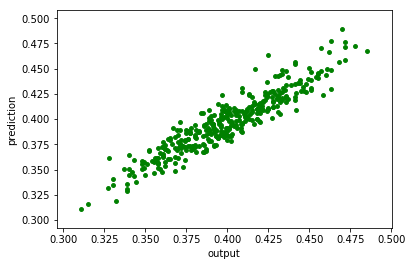

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Predict test data
test_results_predict = lr_model.transform(test_df)
test_results_predict_pd = test_results_predict.toPandas()
test_results_predict_pd.plot.scatter(x = 'output', y = 'prediction', s = 15, c = 'green');
test_results_predict.show(5)